In [2]:
import os
from dataclasses import dataclass

from hydra import compose, initialize
import numpy as np
import xarray as xr
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs

## Metrics 

In [10]:
def avg_monthly(ds, *args):
    return ds.resample(time="1ME").mean()


def get_above_quantile_days(ds, quantile_ds):
    return (ds > quantile_ds).resample(time="1ME").sum()


def avg_hot_day_intensity(ds, quantile_ds):
    intense_day_mask = (ds > quantile_ds).astype(int)

    masked_days = ds * intense_day_mask

    return masked_days.resample(time="1ME").mean()


def get_above_quantile_streak(ds, quantile_ds):
    def compute_streak(ds):
        """Helper function to compute the streak of a dataset"""
        intense_days = (ds > quantile_ds).astype(int)
        # Keep track of the consecutive days
        streak = intense_days.isel(time=0)

        # Cumulative sum of the streak
        for day in intense_days.time:
            streak = (streak * intense_days.sel(time=day)) + 1

        # Account for the duplicate first day
        streak -= 1
        return streak

    return ds.resample(time="1ME").map(compute_streak)


def get_wet_days(ds, *args):
    return (ds > 1).resample(time="1ME").sum()


def get_wet_streak(ds, *args):
    def compute_streak(ds):
        """Helper function to compute the streak of a dataset"""
        intense_days = (ds > 1).astype(int)
        # Keep track of the consecutive days
        streak = intense_days.isel(time=0)

        # Cumulative sum of the streak
        for day in intense_days.time:
            streak = (streak * intense_days.sel(time=day)) + 1

        # Account for the duplicate first day
        streak -= 1
        return streak

    return ds.resample(time="1ME").map(compute_streak)


def get_dry_days(ds, *args):
    return (ds < 0.1).resample(time="1ME").sum()


def get_sdii(ds, *args):
    # Average precipitation on days with more than 1mm of precip
    with xr.set_options(keep_attrs=True):
        return ds.where(ds > 1).resample(time="1ME").mean(skipna=True)


METRIC_FN_DICT = {
    "tas": [
        avg_monthly,
        get_above_quantile_days,
        avg_hot_day_intensity,
        get_above_quantile_streak,
    ],
    "pr": [avg_monthly, get_wet_days, get_wet_streak, get_sdii],
}

METRIC_NAMES_DICT = {
    "tas": [
        "Average Monthly Temperature",
        "Days Above 90th Percentile",
        "Average Temperature on Days Above 90th Percentile",
        "Average Hot Streak",
    ],
    "pr": [
        "Average Monthly Precipitation",
        "Average Rainy Days",
        "Average Rainy Streak",
        "Average SDII",
    ],
}

METRIC_HIST_AXES = {
    "tas": [
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-2, 2, 40),
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-1.5, 1.5, 40),
    ],
    "pr": [
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-1, 1, 64),
        np.linspace(-3.0, 3.0, 64),
        np.linspace(-1.0, 1.0, 40),
    ],
}

CMAPS = {"tas": "bwr", "pr": "BrBG"}


@dataclass
class Location:
    lat: int
    lon: int


LOCS = {
    "Hawaii": Location(20, 156),
    "Melbourne": Location(-38, 145),
    "Novosibirsk": Location(55, 83),
}

UNITS = {"tas": "°C", "pr": "mm/day"}

## Loading Data

In [5]:
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="data_viz")

# Construct the path to the saved data
data_path = os.path.join(cfg.paths.save_dir, cfg.esm, cfg.scenario)

# Construct the file names for the gen/val/test files
gen_prefix = cfg.gen_prefix + "_" if cfg.gen_prefix is not None else ""

gen_file = f"gen_{cfg.var}_{gen_prefix}{cfg.start_year}-{cfg.end_year}.nc"
val_file = f"val_{cfg.var}_{cfg.start_year}-{cfg.end_year}.nc"
test_file = f"test_{cfg.var}_{cfg.start_year}-{cfg.end_year}.nc"

# Open up the datasets
gen_set = xr.open_dataset(os.path.join(data_path, gen_file))[cfg.var]
val_set = xr.open_dataset(os.path.join(data_path, val_file))[cfg.var]
test_set = xr.open_dataset(os.path.join(data_path, test_file))[cfg.var]


# Load the quantile data
quantile_path = os.path.join(cfg.paths.quantile_dir, cfg.esm, cfg.var + "_90.nc")
quantile_ds = xr.open_dataset(quantile_path)[cfg.var]

## Generating Metric Visualizations

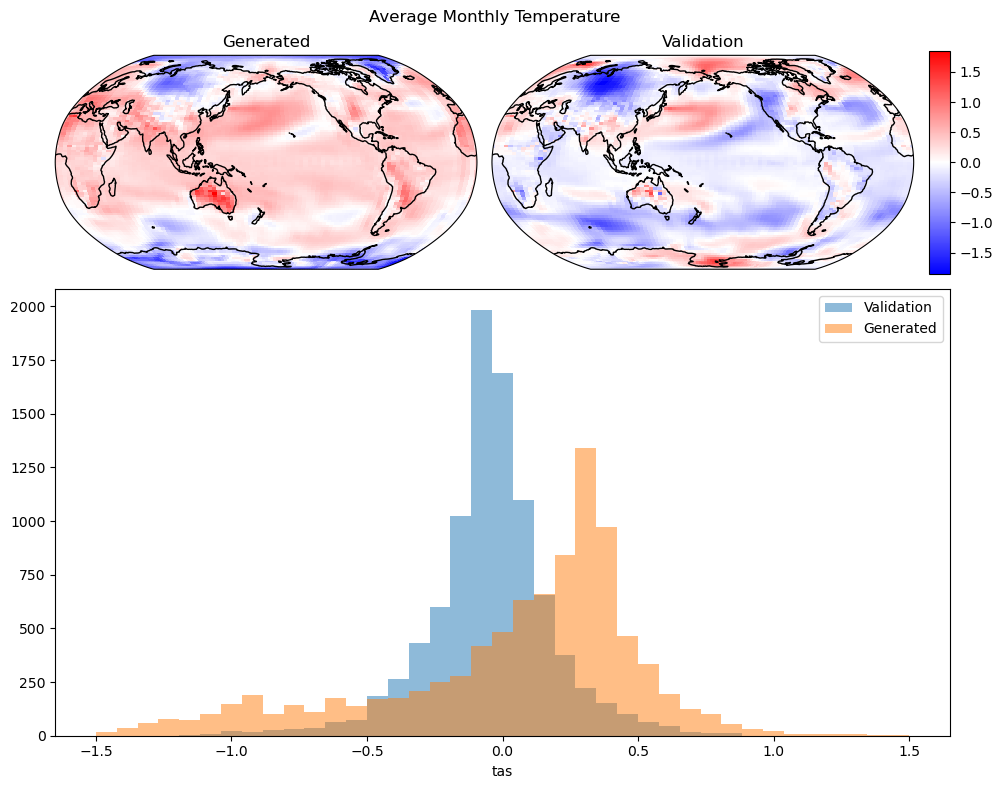

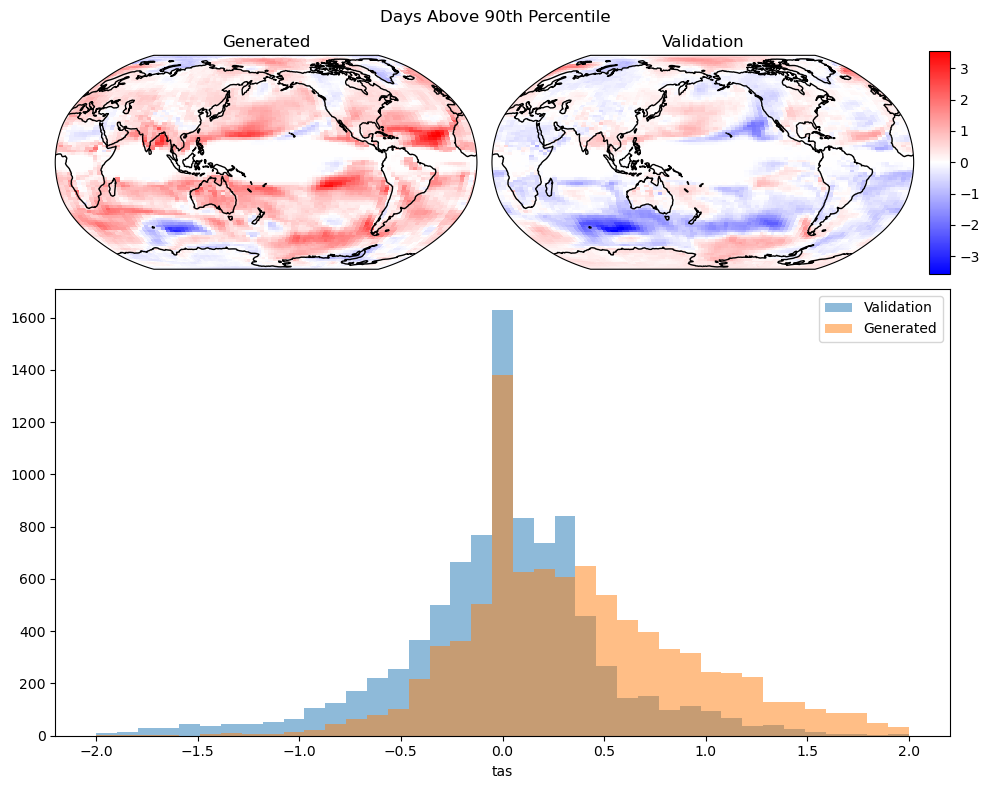

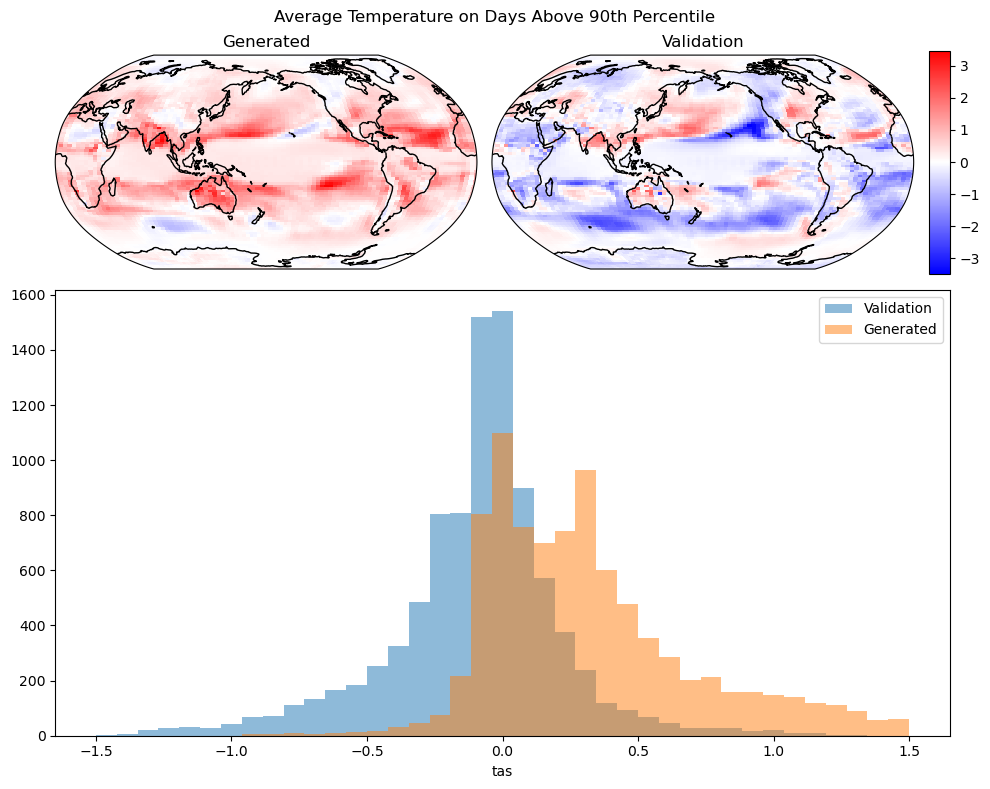

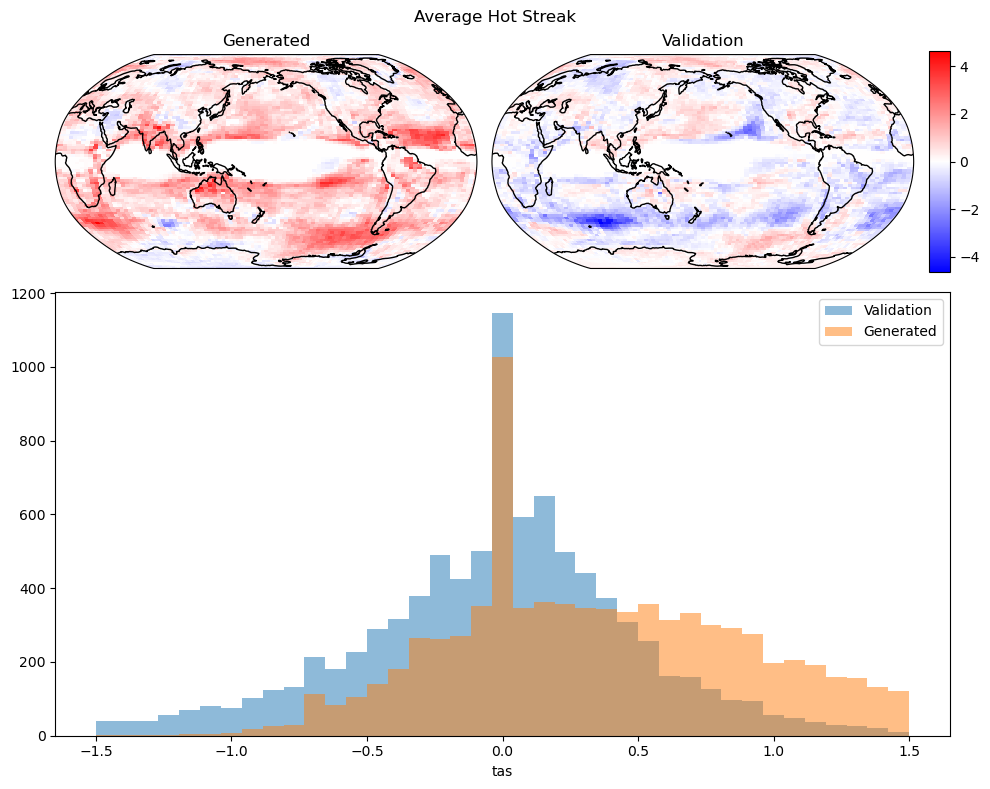

In [4]:
var = cfg.var
cmap = CMAPS[var]

# Iterate through every metric, the name, and the xaxis limits
for metric, name, bin_range in zip(
    METRIC_FN_DICT[var], METRIC_NAMES_DICT[var], METRIC_HIST_AXES[var]
):
    # Calculate the metric for each of the generated / validation / test sets
    gen_results = metric(gen_set, quantile_ds)
    val_results = metric(val_set, quantile_ds)
    test_results = metric(test_set, quantile_ds)

    # Calculate the difference between the gen/val/test sets
    gen_diff = (gen_results - test_results).mean(dim="time")
    val_diff = (val_results - test_results).mean(dim="time")

    fig = plt.figure(figsize=(10, 8))

    # Setup the grid layout - Make the colorbar axis very narrow
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 0.05])

    # Create the subplots
    ax1 = plt.subplot(
        gs[0, 0], projection=ccrs.Robinson(central_longitude=180)
    )  # First plot in the first row
    ax2 = plt.subplot(
        gs[0, 1], projection=ccrs.Robinson(central_longitude=180)
    )  # Second plot in the first row
    ax3 = plt.subplot(gs[1, :])  # Third plot in the second row spanning all columns

    cbar_ax = plt.subplot(gs[0, 2])  # Colorbar in the first row, third column

    # Save the generated difference to use in the colorbar
    a = gen_diff.plot(
        ax=ax1, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree()
    )
    val_diff.plot(ax=ax2, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree())

    # Add coastlines to the maps
    ax1.coastlines()
    ax2.coastlines()

    # Title each axis
    ax1.set_title("Generated")
    ax2.set_title("Validation")

    # Plot the histograms
    val_diff.plot.hist(ax=ax3, bins=bin_range, alpha=0.5, label="Validation")
    gen_diff.plot.hist(ax=ax3, bins=bin_range, alpha=0.5, label="Generated")
    ax3.legend()

    fig.colorbar(a, cax=cbar_ax, orientation="vertical")
    # Add a title to the figure
    fig.suptitle(name)

    plt.tight_layout()

## KS Test

In [5]:
def ks_test(series1, series2):
    return ks_2samp(series1, series2).statistic

### First, calculate the KS matrices

In [6]:
gen_ks = xr.apply_ufunc(
    ks_test,
    gen_set,
    val_set,
    input_core_dims=[["time"], ["time"]],
    vectorize=True,
    dask="allowed",
)


val_ks = xr.apply_ufunc(
    ks_test,
    val_set,
    test_set,
    input_core_dims=[["time"], ["time"]],
    vectorize=True,
    dask="allowed",
)

### Then, run this to plot

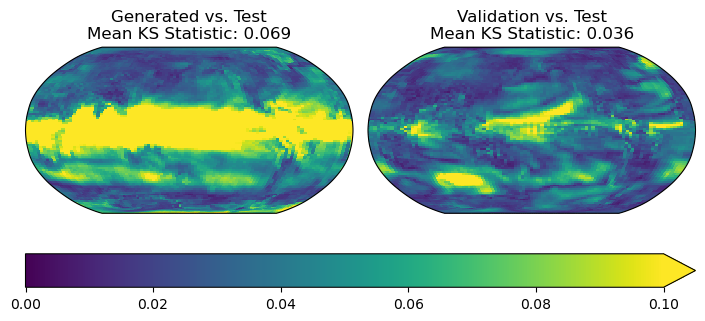

In [7]:
combined = xr.Dataset({"Generated": gen_ks, "Validation": val_ks})
p = combined.to_array().plot(
    col="variable",
    vmin=0,
    vmax=0.10,
    subplot_kws={"projection": ccrs.Robinson(central_longitude=180)},
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal"},
)

titles = [
    f"Generated vs. Test\nMean KS Statistic: {gen_ks.mean():.3f}",
    f"Validation vs. Test\nMean KS Statistic: {val_ks.mean():.3f}",
]

for i, ax in enumerate(p.axs.flat):
    ax.set_title(titles[i])

## Generate Line Plots

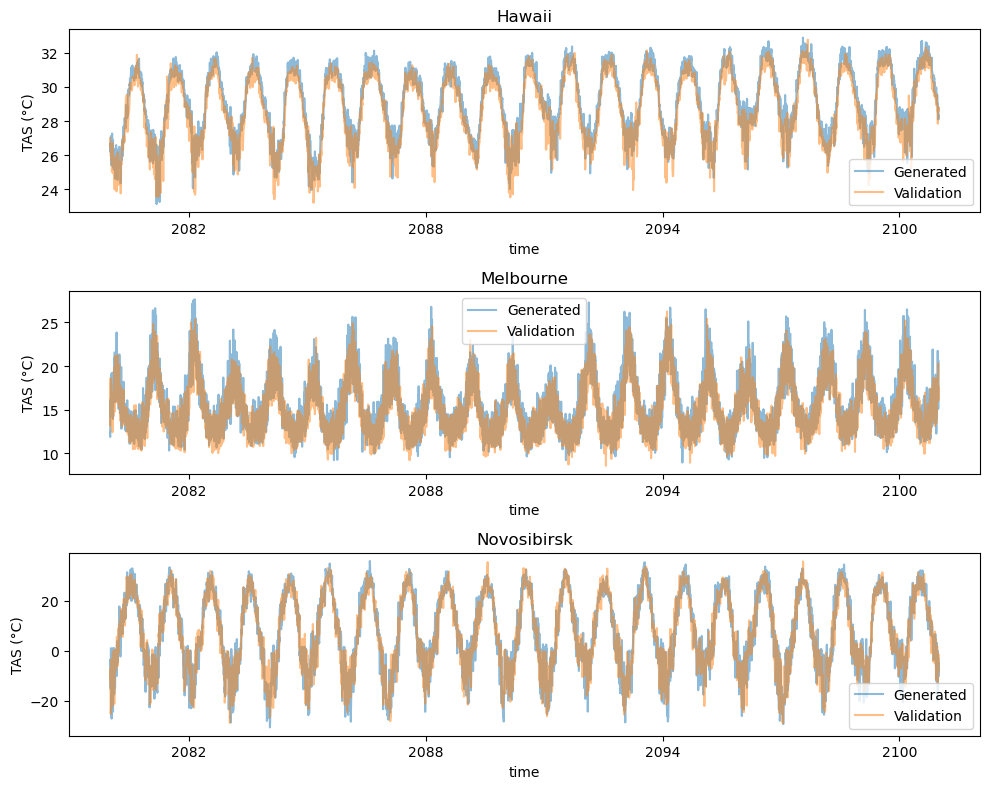

In [11]:
# Create three plots for Hawaii, Melbourne, and Novosibirsk
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot the generated and validation data for each location
for ax, loc, loc_title in zip(axes, LOCS.values(), LOCS.keys()):
    # Plot the generated and validation data for each location, specify units (celsius or mm/day)
    gen_set.sel(lat=loc.lat, lon=loc.lon, method="nearest").plot.line(
        ax=ax, label="Generated", alpha=0.5
    )
    val_set.sel(lat=loc.lat, lon=loc.lon, method="nearest").plot.line(
        ax=ax, label="Validation", alpha=0.5
    )

    # Add units to the yaxis
    ax.set_ylabel(f"{cfg.var.upper()} ({UNITS[cfg.var]})")

    ax.set_title(loc_title)
    ax.legend()


plt.tight_layout()